<a href="https://colab.research.google.com/github/luthfiyahastutiningtyas/etl-project/blob/main/DQLab_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Koneksi Ke Google Big Query**

In [ ]:
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery
from pandas_gbq import to_gbq
import pandas as pd
import numpy as np

# PRoses autentikasi akun
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

# Buat BigQuery client
project_id = 'dqlabkomdigi'
bq_client = bigquery.Client(project = project_id)

# **Proses Ekstraksi Data dari sumber (Extract)**

### **Proses Ekstraksi Data Transaksi**

In [ ]:
%%bigquery data_transaksi --project {project_id}

-- Tulis Query disini
SELECT * FROM dqlab-468906.dqcommerce.tbl_transaction

Query is running:   0%|          |

Downloading:   0%|          |

### **Proses Ekstraksi Data Product**

In [ ]:
%%bigquery data_product --project {project_id}

-- Tulis Query disini
SELECT * FROM dqlab-468906.dqcommerce.tbl_product

Query is running:   0%|          |

Downloading:   0%|          |

### **Proses Ekstraksi Data Funnel**

In [ ]:
%%bigquery data_funnel --project {project_id}

-- Tulis Query disini
SELECT * FROM dqlab-468906.dqcommerce.tbl_funnel

Query is running:   0%|          |

Downloading:   0%|          |

Setelah query dijalankan maka akan disimpan sebagai dataframe pandas

## **Periksa Informasi Umum pada Data**

In [ ]:
# Periksa info umum pada data
data_transaksi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829262 entries, 0 to 829261
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   trx_id      829257 non-null  object
 1   product_id  829262 non-null  object
 2   trx_date    829262 non-null  Int64 
 3   trx_time    829262 non-null  dbtime
 4   units       829251 non-null  Int64 
dtypes: Int64(2), dbtime(1), object(2)
memory usage: 33.2+ MB


In [ ]:
# Periksa info umum pada data
data_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_id        37 non-null     object
 1   product_name      37 non-null     object
 2   product_category  37 non-null     object
 3   product_cost      37 non-null     object
 4   product_price     37 non-null     object
dtypes: object(5)
memory usage: 1.6+ KB


In [ ]:
# Periksa info umum pada data
data_funnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15950 entries, 0 to 15949
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         15950 non-null  Int64 
 1   product_id   15950 non-null  object
 2   purchase     15950 non-null  Int64 
 3   add_to_cart  15950 non-null  Int64 
 4   click        15950 non-null  Int64 
 5   view         15950 non-null  Int64 
dtypes: Int64(5), object(1)
memory usage: 825.7+ KB


# **Proses Transformasi Data (Transform)**

### **Transformasi Data Transaksi**

- Ubah kolom trx_date DDMMYYYY menjadi YYYY-MM-DD lalu konversi ke tipe data DATE
- Hapus data yang trx_id nya kosong
- Isikan 0 pada kolom units yang kosong
- Periksa duplikasi data, jika terdapat data yang duplikat hapus salah satunya


#### Konversi trx_date

In [ ]:
# Konversi kolom trx_date dari Integer menjadi string
data_transaksi['trx_date'] = data_transaksi['trx_date'].astype('str')

# Buat kondisi
data_transaksi['trx_date'] = np.where(data_transaksi['trx_date'].str.len() == 7, '0' + data_transaksi['trx_date'], data_transaksi['trx_date'])

# Konversi ke date
data_transaksi['trx_date'] = pd.to_datetime(data_transaksi['trx_date'], format = '%d%m%Y')
data_transaksi.sample(10)

#### Hapus data dengan trx_id yang kosong

In [ ]:
# Data asli (sebelum di drop)
data_transaksi.shape

(829262, 5)

In [ ]:
# Hapus data yang kosong
data_transaksi = data_transaksi[data_transaksi['trx_id'].notnull()]
data_transaksi.shape

(829257, 5)

#### Isikan 0 pada kolom units yang kosong

In [ ]:
data_transaksi['units'] = data_transaksi['units'].fillna(0)

#### Periksa duplikasi data

In [ ]:
data_transaksi.duplicated(subset = 'trx_id').sum()

np.int64(0)

#### Tampilkan hasil akhir hasil transformasi

In [ ]:
data_product.head()

,product_id,product_name,product_category,product_cost,product_price
0,DQProduk-009,Pulpen Metal DQLab,Alat Tulis,IDR 149850,IDR 164850
1,DQProduk-003,Sticky Notes DQLab,Alat Tulis,IDR 29850,IDR 59850
2,DQProduk-025,Tipe-X Roller DQLab,Alat Tulis,IDR 29850,IDR 44850
3,DQProduk-016,Set Pulpen DQLab,Alat Tulis,IDR 44850,IDR 149850
4,DQProduk-028,Penanda Warna DQLab,Alat Tulis,IDR 59850,IDR 164850


### **Transformasi Data Product**

- Ubah kolom product_cost dan product_price menjadi kolom angka dengan menghapus simbol mata uang
- Periksa duplikasi data, jika terdapat data yang duplikat hapus salah satunya


#### Transformasi kolom product_cost dan product_price

In [ ]:
for col in ['product_cost', 'product_price']:
    data_product[col] = data_product[col].str.replace('IDR ', '')
    data_product[col] = data_product[col].astype(pd.Int64Dtype())

#### Periksa duplikasi data

In [ ]:
data_product.duplicated().sum()

np.int64(2)

In [ ]:
data_product[data_product.duplicated(subset='product_id', keep = False)]

,product_id,product_name,product_category,product_cost,product_price
17,DQProduk-035,Kartu Ucapan DQLab,Kertas & Cetak,59850,119850
18,DQProduk-035,Kartu Ucapan DQLab,Kertas & Cetak,59850,119850
27,DQProduk-015,Mousepad Custom DQLab,Merchandise,59850,89850
28,DQProduk-015,Mousepad Custom DQLab,Merchandise,59850,89850


#### Hapus duplikasi data

In [ ]:
data_product.shape

(37, 5)

In [ ]:
data_product = data_product.drop_duplicates(subset = ['product_id'], keep = 'first')
data_product.shape

(35, 5)

### **Proses Integrasi Data Transaksi dan Data Product**

In [ ]:
data_integration = data_transaksi.merge(data_product, on = 'product_id', how = 'left')
data_integration.head()

,trx_id,product_id,trx_date,trx_time,units,product_name,product_category,product_cost,product_price
0,DQTrx829214,DQProduk-016,2025-09-30,01:18:05,0,Set Pulpen DQLab,Alat Tulis,44850,149850
1,DQTrx829166,DQProduk-017,2025-09-30,18:58:33,0,Set Tulis Eksekutif DQLab,Merchandise,209850,299850
2,DQTrx829118,DQProduk-018,2025-09-30,06:58:09,0,Printer Mini DQLab,Elektronik,524850,599850
3,DQTrx829186,DQProduk-019,2025-09-30,09:28:13,0,Kertas Warna DQLab,Kertas & Cetak,209850,239850
4,DQTrx829212,DQProduk-019,2025-09-30,15:00:55,0,Kertas Warna DQLab,Kertas & Cetak,209850,239850


# **Proses Simpan Data (Load)**

In [ ]:
import pandas as pd

# Upload ke BigQuery - tabel belum ada
to_gbq(
    data_integration,
    destination_table = 'tbl_dwh_dqcommerce.tbl_integration',
    project_id = project_id,
    if_exists = 'fail'
)

100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


Pastikan data integrasi telah tersimpan di google big query

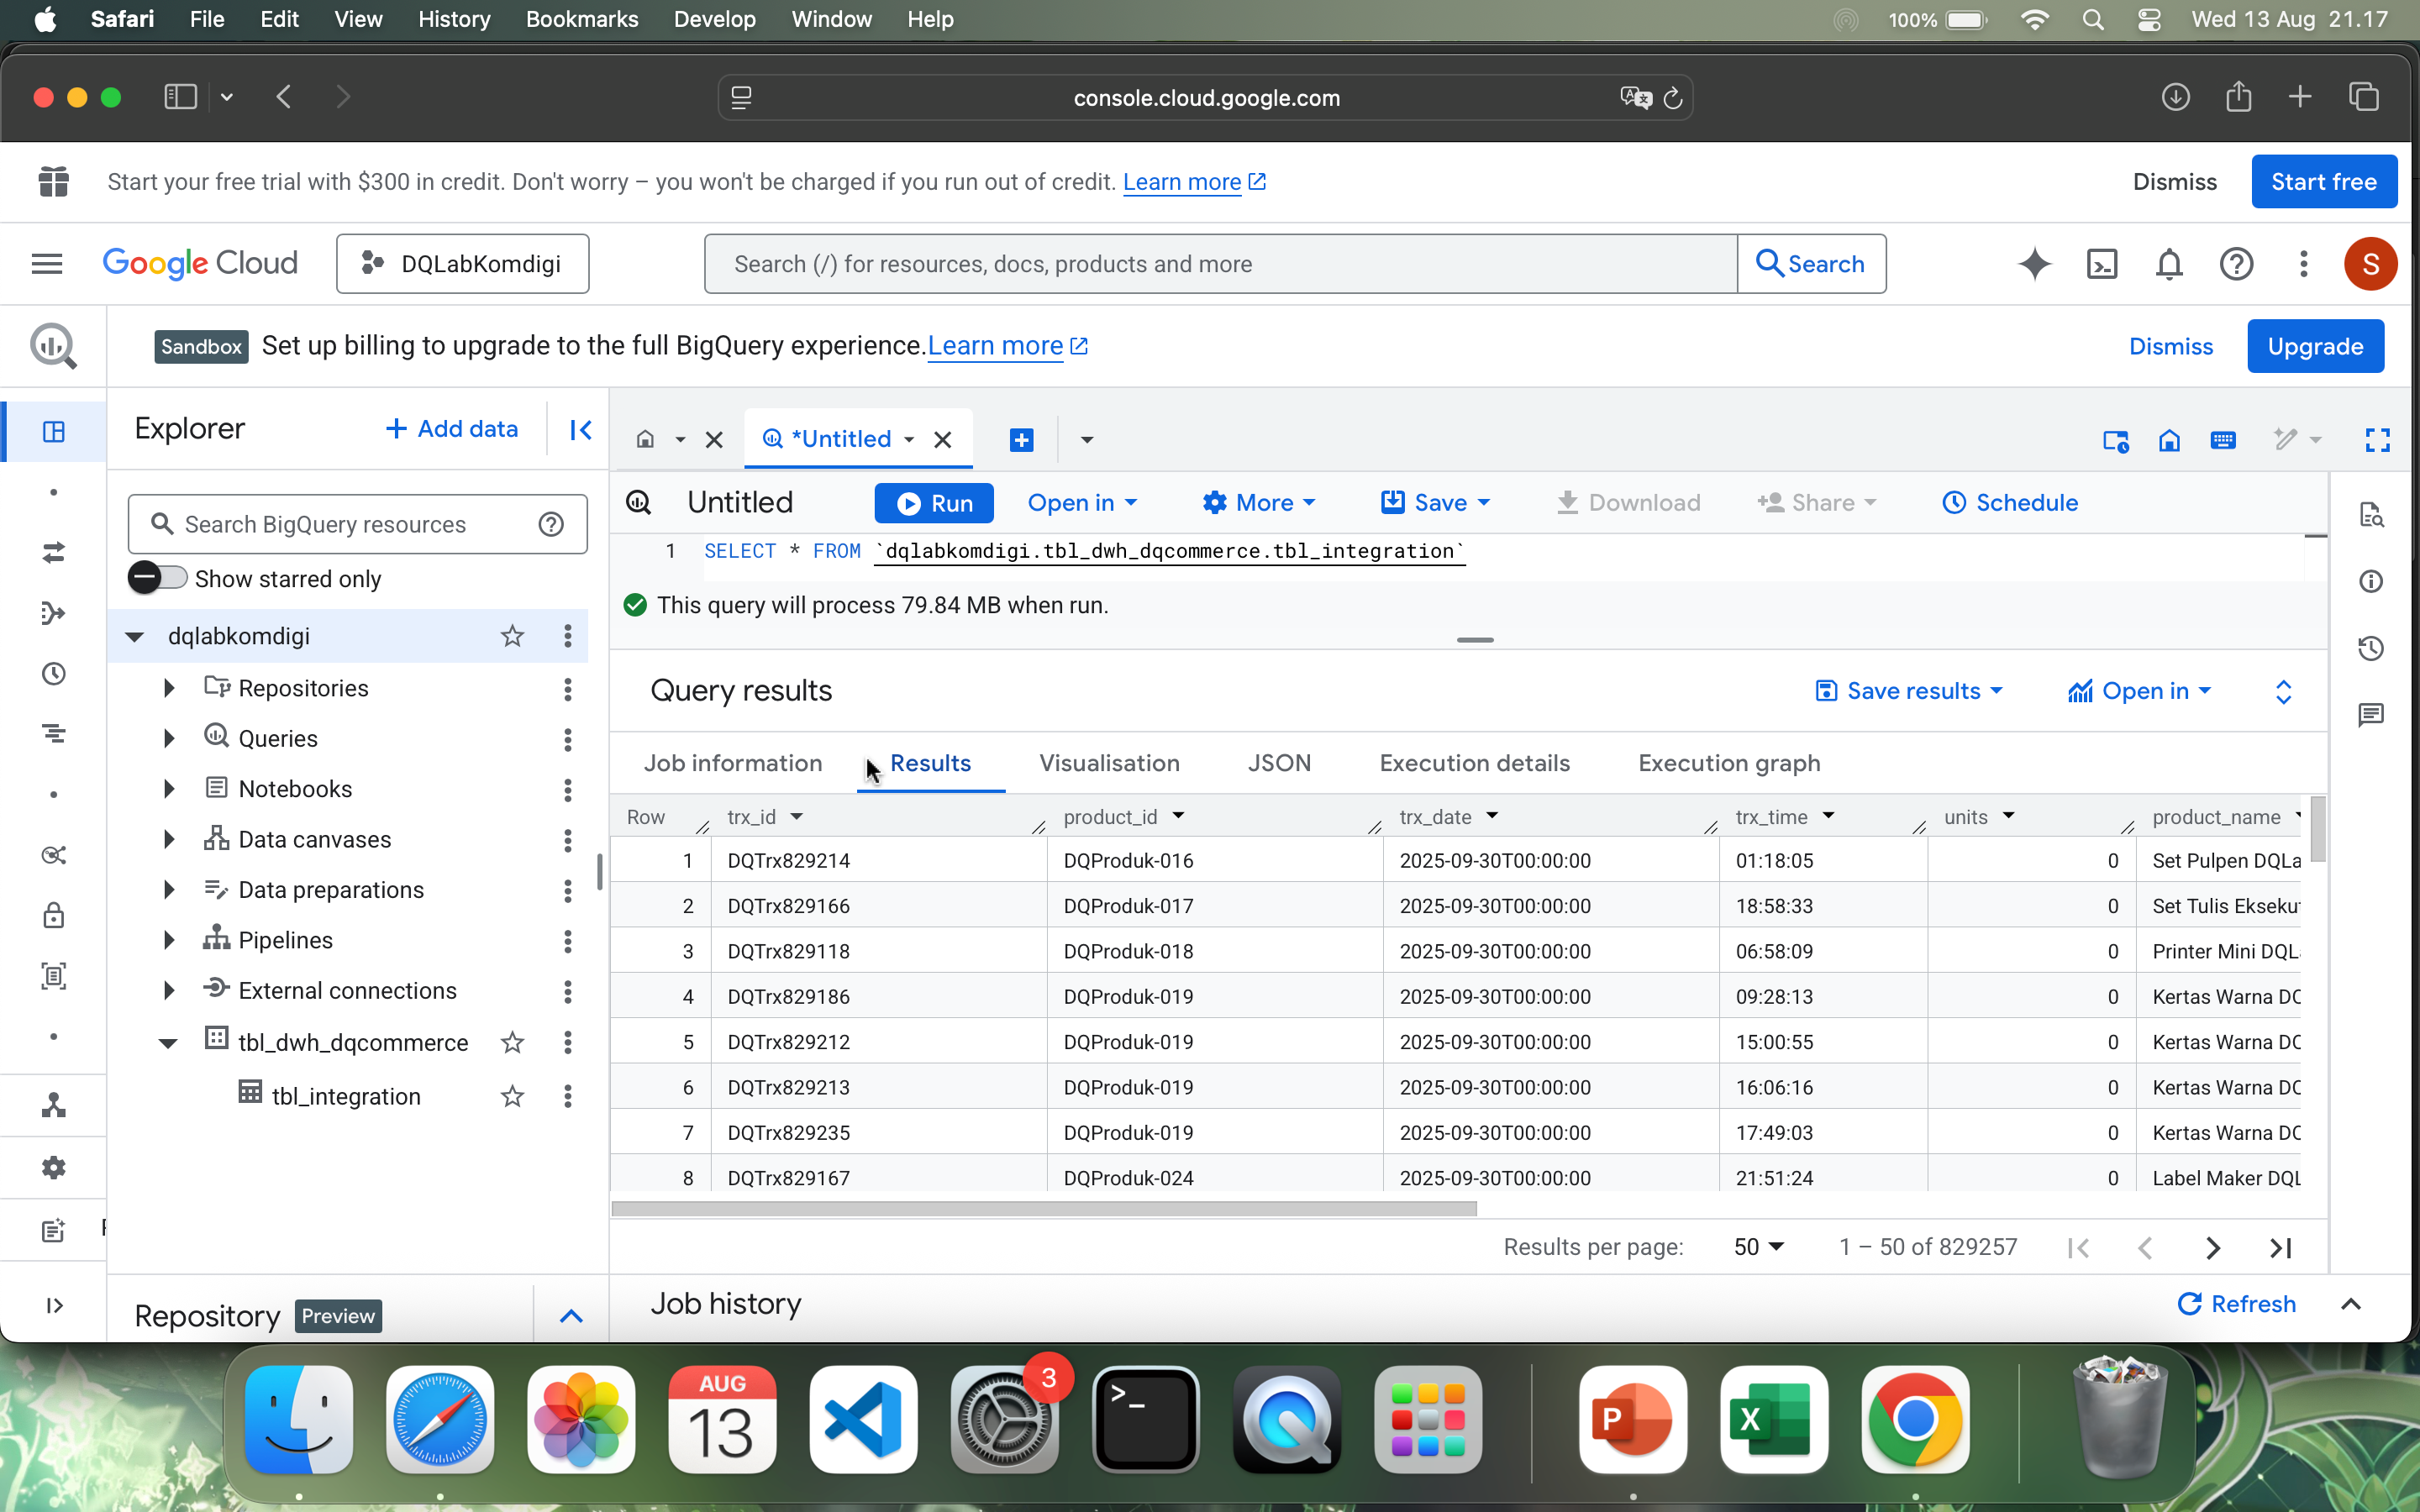

---

# **Analisis Data**

### Overview Total Penjualan Periode Data Tiap Bulan

In [ ]:
data_transaksi['month_year'] = data_transaksi['trx_date'].dt.strftime('%Y-%m')
data_transaksi.head()

,trx_id,product_id,trx_date,trx_time,units,month_year
0,DQTrx829214,DQProduk-016,2025-09-30,01:18:05,<NA>,2025-09
1,DQTrx829166,DQProduk-017,2025-09-30,18:58:33,<NA>,2025-09
2,DQTrx829118,DQProduk-018,2025-09-30,06:58:09,<NA>,2025-09
3,DQTrx829186,DQProduk-019,2025-09-30,09:28:13,<NA>,2025-09
4,DQTrx829212,DQProduk-019,2025-09-30,15:00:55,<NA>,2025-09


In [ ]:
penjualan_bulanan = data_transaksi.groupby(['month_year'], as_index = False).agg(total = ('units', 'sum'))
penjualan_bulanan.head()

,month_year,total
0,2024-01,38009
1,2024-02,36935
2,2024-03,39981
3,2024-04,47102
4,2024-05,46910


In [ ]:
import plotly.express as px

# Membuat line chart
fig = px.line(
    penjualan_bulanan,
    x="month_year",
    y="total",
    title="<b>Grafik Total Penjualan Bulanan DQ-Commerce</b>",
    color_discrete_sequence = ['#39074E'],
    markers=False)

"""
fig.add_vrect(
    x0="2025-03", x1="2025-09",
    fillcolor="#E73c35",
    opacity=0.5,
    layer="below",
    line_width=0,
    #annotation_text="Tahun 2025",
    #annotation_position="top "
)
"""

fig.update_layout(
    height = 450,
    width = 1100,
    plot_bgcolor = 'rgba(0, 0, 0, 0)',
    yaxis = dict(
        showline = True,
        linewidth = 1,
        color = '#544018',
        linecolor = '#544018',
        showgrid=False,
    ),
    xaxis = dict(
        title = '',
        showline = True,
        linewidth = 1,
        color = '#544018',
        linecolor = '#544018',
        showgrid=False,
    ),
)

fig.show()

In [ ]:
penjualan_per_produk = data_transaksi.groupby(['month_year', 'product_id'], as_index = False).agg(total = ('units', 'sum'))
penjualan_per_produk.head()

,month_year,product_id,total
0,2024-01,DQProduk-001,3441
1,2024-01,DQProduk-002,1513
2,2024-01,DQProduk-003,76
3,2024-01,DQProduk-004,166
4,2024-01,DQProduk-005,276


In [ ]:
import plotly.express as px

# Membuat line chart
fig = px.line(
    penjualan_per_produk, #[penjualan['month_year'] >= '2025-01'],
    x="month_year",
    y="total",
    color="product_id",
    title="<b>Grafik Total Penjualan Bulanan DQ-Commerce Per Produk</b>",
    markers=True
)

fig.update_layout(
    height = 550,
    width = 1200,
    plot_bgcolor = 'rgba(0, 0, 0, 0)',
    yaxis = dict(
        showline = True,
        linewidth = 1,
        color = '#544018',
        linecolor = '#544018',
        showgrid=False,
    ),
    xaxis = dict(
        title = '',
        showline = True,
        linewidth = 1,
        color = '#544018',
        linecolor = '#544018',
        showgrid=False,
    ),
)

fig.show()

In [ ]:
import plotly.graph_objects as go

highlight_product = ['DQProduk-003', 'DQProduk-019', 'DQProduk-025', 'DQProduk-018', 'DQProduk-031']

fig = go.Figure()

# Loop setiap produk
for product in penjualan_per_produk['product_id'].unique():
    df_product = penjualan_per_produk[penjualan_per_produk['product_id'] == product]

    # Tentukan properti styling
    if product in highlight_product:
        line_color = 'purple'
        line_width = 3
    else:
        line_color = 'lightgray'
        line_width = 1.2

    # Tambahkan trace
    fig.add_trace(go.Scatter(
        x=df_product['month_year'],
        y=df_product['total'],
        mode='lines+markers',
        name=product,
        line=dict(
            width=line_width,
            color=line_color
        )
    ))

# Layout styling
fig.update_layout(
    title="<b>Grafik Total Penjualan Bulanan DQ-Commerce Per Produk</b>",
    height=550,
    width=1200,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    xaxis=dict(
        showline=True,
        linewidth=1,
        color='#544018',
        linecolor='#544018',
        title='',
        showgrid=False,
    ),
    yaxis=dict(
        showline=True,
        linewidth=1,
        color='#544018',
        linecolor='#544018',
        showgrid=False,
    )
)

fig.show()